- エンゼルの予測を金と銀合わせて行う

In [99]:
import os, sys
import numpy as np
import pandas as pd
import scipy.stats as stats

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm


import ChocoUtils as cu

In [2]:
sns.set()

# データの取得
- campaign=1は「金のエンゼル2倍キャンペーン」

In [5]:
data = cu.get_data(db_file='/home/yoichi/workspace/choco-ball-statistics/data/choco-ball.db', 
                   filter_str="taste is not 10")
data = data.drop(columns=['shop', 'factory'])
data.head()

SELECT measure_date, best_before, prd_number, weight, box_weight, ball_number, factory, shop, angel, campaign, taste, buyer, (weight - box_weight), (weight - box_weight)/ball_number FROM measurement WHERE taste is not 10;
Shape of MeasurementData(record_num, n_columns) : (562, 14)


,measure_date,best_before,prd_number,weight,box_weight,ball_number,angel,campaign,taste,buyer,net_weight,mean_weight
0,2017-11-19,None,None,34.002,4.756,16,0,1,0,時田,29.246,1.827875
1,2017-11-20,None,None,34.435,4.805,17,0,1,0,時田,29.630,1.742941
2,2017-11-21,2018-06-01,None,34.000,4.815,18,0,1,0,時田,29.185,1.621389
3,2017-11-22,2018-06-01,None,34.193,4.818,17,0,1,0,時田,29.375,1.727941
4,2017-11-23,2018-06-01,None,35.344,4.836,16,0,1,0,時田,30.508,1.906750


# エンゼル出現確率の推定

## データの前処理
- モデルが想定する形にデータを加工

In [8]:
data_1 = data.query('campaign == 1')
data_0 = data.query('campaign != 1')

In [20]:
dict_sum = dict()
dict_sum['c1'] = {'gold':sum(data_1['angel']==2), 
                  'silver':sum(data_1['angel']==1), 
                  'none':sum(data_1['angel']==0)
                 }
dict_sum['c0'] = {'gold':sum(data_0['angel']==2), 
                  'silver':sum(data_0['angel']==1), 
                  'none':sum(data_0['angel']==0)
                 }
df_sum = pd.DataFrame(dict_sum).T
df_sum = df_sum[['none', 'silver', 'gold']]
df_sum

,none,silver,gold
c1,113,0,1
c0,428,20,0


## モデルの作成
- 金2倍のデータを除外したパターン

In [88]:
d = df_sum.loc['c0'].values
d

array([428,  20,   0])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [pi]
Sampling 3 chains: 100%|██████████| 31500/31500 [00:12<00:00, 2494.08draws/s]
/home/yoichi/workspace/choco-ball-statistics/env_choco/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f50f238bdd8>,
      dtype=object)

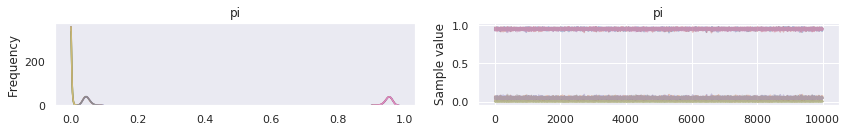

In [89]:
with pm.Model() as model1:
    alpha = [1., 1., 1.]
    pi = pm.Dirichlet('pi', a=np.array(alpha))
    m = pm.Multinomial('m', n=np.sum(d), p=pi, observed=d)
    trace1 = pm.sample(10000, chains=3)
pm.traceplot(trace1)

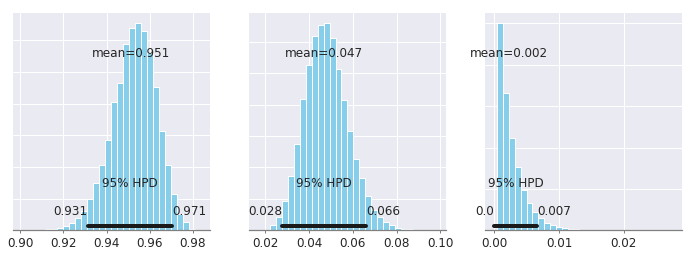

In [95]:
fig = plt.figure(figsize=(12, 4))
ax = fig.subplots(1, 3)

pm.plot_posterior(trace1['pi'][:,0], ax=ax[0])
pm.plot_posterior(trace1['pi'][:,1], ax=ax[1])
pm.plot_posterior(trace1['pi'][:,2], ax=ax[2])

## モデル
- 金の2倍期間を入れる

In [91]:
d = df_sum.values
d

array([[113,   0,   1],
       [428,  20,   0]])

In [92]:
weight = np.array([[1.0, 0.0, 2.0], 
                   [1.0, 1.0, 1.0]])
weight

array([[1., 0., 2.],
       [1., 1., 1.]])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [pi]
Sampling 3 chains: 100%|██████████| 31500/31500 [00:10<00:00, 2900.61draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f50f3e2b2e8>,
      dtype=object)

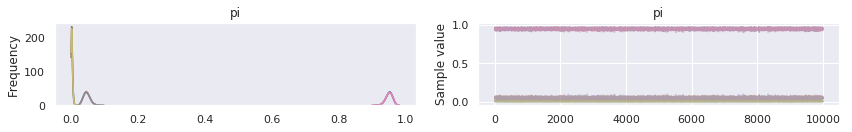

In [93]:
with pm.Model() as model2:
    alpha = [1., 1., 1.]
    pi = pm.Dirichlet('pi', a=np.array(alpha))
    for i in np.arange(d.shape[0]):
        m = pm.Multinomial('m_%s'%(i), n=np.sum(d[i]), p=pi*weight[i], observed=d[i])
    trace2 = pm.sample(10000, chains=3)
pm.traceplot(trace)

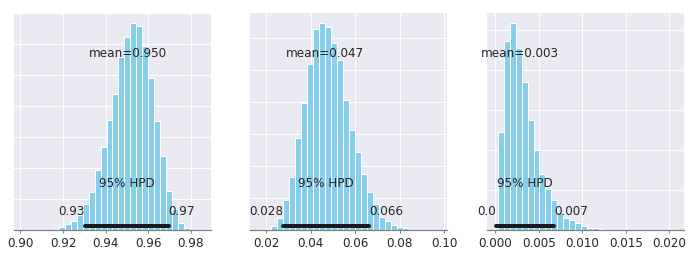

In [96]:
fig = plt.figure(figsize=(12, 4))
ax = fig.subplots(1, 3)

pm.plot_posterior(trace2['pi'][:,0], ax=ax[0])
pm.plot_posterior(trace2['pi'][:,1], ax=ax[1])
pm.plot_posterior(trace2['pi'][:,2], ax=ax[2])

# いくら買えば金or銀のエンゼルが当たるか

In [104]:
n=5
ks = np.arange(0,300,1)
p_trace = trace2['pi'][:,1]
pmf_arr = np.array(list(map(lambda p:stats.nbinom.pmf(ks, n, p), p_trace)))
pmf_expect = pmf_arr.mean(axis=0)
cdf_expect = (pmf_arr.cumsum(axis=1)).mean(axis=0)

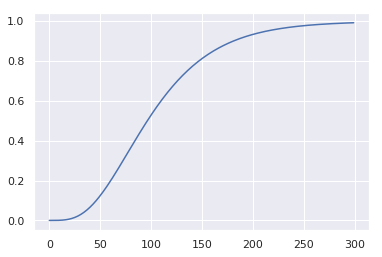

In [105]:
plt.plot(cdf_expect)

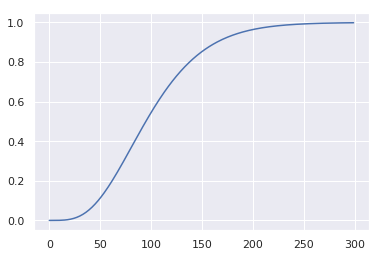

In [106]:
plt.plot(stats.nbinom.cdf(ks, n, p_trace.mean()))

In [111]:
n=1
ks = np.arange(0,2000,1)
p_trace = trace2['pi'][:,2]
pmf_arr = np.array(list(map(lambda p:stats.nbinom.pmf(ks, n, p), p_trace)))
pmf_expect = pmf_arr.mean(axis=0)
cdf_expect = (pmf_arr.cumsum(axis=1)).mean(axis=0)

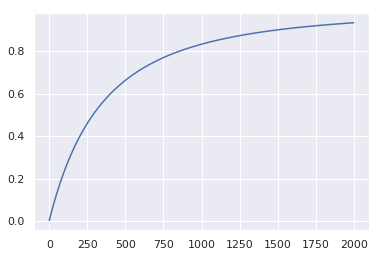

In [112]:
plt.plot(cdf_expect)

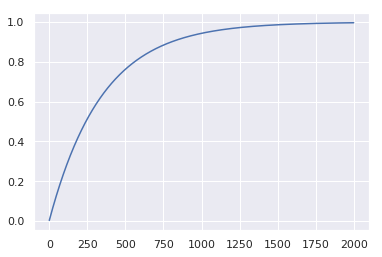

In [113]:
plt.plot(stats.nbinom.cdf(ks, n, p_trace.mean()))